In [2]:
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix
import math
import operator
from sklearn.preprocessing import normalize
import numpy as np 
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from collections import defaultdict
from sklearn.metrics import accuracy_score
import random

In [118]:
df=pd.read_csv("temp_data3.csv")
df=df.iloc[:50,:]

In [119]:
list1=[]
list1=df.Sentiment.values
for i in range(len(list1)):
    if(list1[i]=="mixed"):
        df.drop([i],axis=0,inplace=True)
    elif(list1[i]=="neutral"):
        df.drop([i],axis=0,inplace=True)

df["Sentiment"].value_counts()

positive    26
negative    13
Name: Sentiment, dtype: int64

In [120]:
text=df["cleaned_text"]
sentiment=df["Sentiment"]
dataf=pd.concat([text,sentiment],axis=1)

In [121]:
data=dataf["cleaned_text"].apply(lambda x: " ".join(x.lower() for x in x.split() if x.isalpha()))
data=data.str.replace("[^\w\s]","")#harf dışı simgeler,noktalama
data= data.str.replace(" \d+", " ")#sayılar 
from nltk.corpus import stopwords
nltk.download("stopwords")
duraklama_kelimeleri = stopwords.words()
data=pd.DataFrame(data,columns=["cleaned_text"])
data=data["cleaned_text"].apply(lambda x: " ".join(x for x in x.split() if x not in duraklama_kelimeleri))
data=pd.concat([data,sentiment],axis=1)

<ipython-input-121-8df99cae8495>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data=data.str.replace("[^\w\s]","")#harf dışı simgeler,noktalama
<ipython-input-121-8df99cae8495>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data= data.str.replace(" \d+", " ")#sayılar
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zehra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
cleaned_text = data['cleaned_text'].values
labels = data['Sentiment'].values

In [123]:
cleaned_text=list(cleaned_text)

In [124]:
def IDF(corpus, unique_words):
    idf_dict={}
    N=len(corpus)
    for i in unique_words:
        count=0
        for sen in corpus:
            if i in sen.split():
                count=count+1#kelimenin kaç dökümanda olduğu
            idf_dict[i]=(math.log((1+N)/(count+1)))+1
    return idf_dict 

In [125]:
def fit(whole_data):
    unique_words = set()
    if isinstance(whole_data, (list,)):
        for x in whole_data:
            for y in x.split():#cümle kelimeleri
                if len(y)<2:
                    continue
                unique_words.add(y)
        unique_words = sorted(list(unique_words))
        vocab = {j:i for i,j in enumerate(unique_words)}#kelime indexleme
    Idf_values_of_all_unique_words=IDF(whole_data,unique_words)
    return vocab, Idf_values_of_all_unique_words
Vocabulary, idf_of_vocabulary=fit(cleaned_text) 

In [126]:
def transform(dataset,vocabulary,idf_values):
    tfidf=np.zeros(len(vocabulary))
    number_of_words_in_sentence=Counter(dataset.split())#yorumdaki kelimelerin sayısı
    for word in dataset.split():
        if word in  list(vocabulary.keys()):#(kelimenin yorumdaki sayısı/yorumun uzunluğu)*kelimenin idf değeri
            tf_idf_value=(number_of_words_in_sentence[word]/len(dataset.split()))*(idf_values[word])
            tfidf[vocabulary[word]]=tf_idf_value
    return tfidf

In [127]:
tablo = np.zeros((len(cleaned_text),len(Vocabulary)))
tablo =pd.DataFrame(tablo,columns=Vocabulary.keys())
tfidf=np.zeros(len(Vocabulary))
for i in range(len(cleaned_text)):
    tfidf=transform(cleaned_text[i],Vocabulary,idf_of_vocabulary)
    tablo.loc[i] = tfidf

In [128]:
tablo=normalize(tablo, norm='l2', axis=1, copy=True, return_norm=False)
tablo =pd.DataFrame(tablo,columns=Vocabulary.keys())

In [130]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [131]:
X, x_te, y, y_te = train_test_split(tablo, encoded_labels, stratify = labels)

In [132]:
X=X.T
x_te=x_te.T

In [154]:
def sigmoid(input):    
    output = 1 / (1 + np.exp(-input))
    return output

In [155]:
def relu(input):
    output = np.maximum(0, input)
    return output

In [156]:
np.random.seed(42)
inputLayer_neurons = X.shape[0]  
hiddenLayer_neurons = 10
outputLayer_neurons = 1  

weights_input_hidden = np.random.uniform(size=(inputLayer_neurons, hiddenLayer_neurons))
weights_hidden_output = np.random.uniform(
    size=(hiddenLayer_neurons, outputLayer_neurons)
)
bias_in=weights_input_hidden[[-1,]]#ağırlık vektörünün son son satırı
bias_out=weights_hidden_output[-1]
lr = 0.0002
epochs = 2000
losses=[]
accuracy=[]

In [157]:
for epoch in range(epochs):
    #İleri Besleme 
    
    hiddenLayer_linearTransform = np.dot(weights_input_hidden.T, X)+bias_in.T
    hiddenLayer_activations = relu(hiddenLayer_linearTransform)

      # Çıkış
    outputLayer_linearTransform = np.dot(weights_hidden_output.T, hiddenLayer_activations)+bias_out
    output = sigmoid(outputLayer_linearTransform)
    
    #Geri Besleme

    error = np.square(y - output) / 2

      # Output-Hidden
    error_output = -(y - output)
    output_wrt_outputLayer_LinearTransform = np.multiply(output, (1 - output))
    outputLayer_LinearTransform_wrt_weights_hidden_output = hiddenLayer_activations

    error_wrt_weights_hidden_output = np.dot(
        outputLayer_LinearTransform_wrt_weights_hidden_output,
        (error_output * output_wrt_outputLayer_LinearTransform).T,
    )

      # Hidden-Input
    outputLayer_LinearTransform_wrt_hiddenLayer_activations = weights_hidden_output
    hiddenLayer_activations_wrt_hiddenLayer_linearTransform = np.multiply(
        hiddenLayer_activations, (1 - hiddenLayer_activations))
    hiddenLayer_linearTransform_wrt_weights_input_hidden = X
    
    error_wrt_weights_input_hidden = np.dot(
        hiddenLayer_linearTransform_wrt_weights_input_hidden,
        (
            hiddenLayer_activations_wrt_hiddenLayer_linearTransform
            * np.dot(
                outputLayer_LinearTransform_wrt_hiddenLayer_activations,
                (output_wrt_outputLayer_LinearTransform * error_output),
            )
        ).T,
    )

    weights_hidden_output -= lr * error_wrt_weights_hidden_output
    weights_input_hidden -= lr * error_wrt_weights_input_hidden
    bias_out=weights_hidden_output[-1]
    bias_in=weights_input_hidden[[-1,]]
    epoch_acc=accuracy_score(y,output[0]>0.49)
    accuracy.append(epoch_acc)

    epoch_loss = np.average(error)
    losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Error epoch {epoch} -> {epoch_loss:f}")
        print(f"Accuracy epoch {epoch} -> {epoch_acc:f}")

Error epoch 0 -> 0.232498
Accuracy epoch 0 -> 0.535004
Error epoch 10 -> 0.232498
Accuracy epoch 10 -> 0.535004
Error epoch 20 -> 0.232498
Accuracy epoch 20 -> 0.535004
Error epoch 30 -> 0.232498
Accuracy epoch 30 -> 0.535004
Error epoch 40 -> 0.232498
Accuracy epoch 40 -> 0.535004
Error epoch 50 -> 0.232498
Accuracy epoch 50 -> 0.535004
Error epoch 60 -> 0.232498
Accuracy epoch 60 -> 0.535004
Error epoch 70 -> 0.232498
Accuracy epoch 70 -> 0.535004
Error epoch 80 -> 0.232498
Accuracy epoch 80 -> 0.535004
Error epoch 90 -> 0.232498
Accuracy epoch 90 -> 0.535004
Error epoch 100 -> 0.232498
Accuracy epoch 100 -> 0.535004
Error epoch 110 -> 0.232498
Accuracy epoch 110 -> 0.535004
Error epoch 120 -> 0.232498
Accuracy epoch 120 -> 0.535004
Error epoch 130 -> 0.232498
Accuracy epoch 130 -> 0.535004
Error epoch 140 -> 0.232498
Accuracy epoch 140 -> 0.535004
Error epoch 150 -> 0.232498
Accuracy epoch 150 -> 0.535004
Error epoch 160 -> 0.232498
Accuracy epoch 160 -> 0.535004
Error epoch 170 -> 

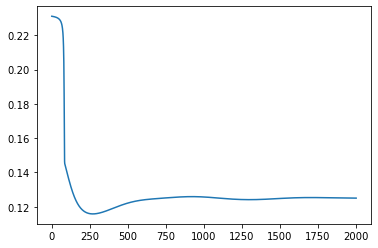

In [81]:
plt.plot(np.arange(1, epochs + 1), np.array(losses))

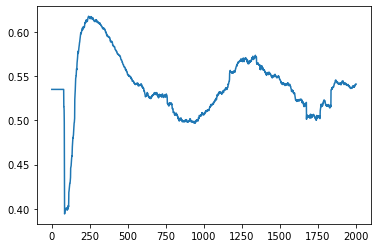

In [82]:
plt.plot(np.arange(1, epochs + 1), np.array(accuracy))

In [158]:
output[0].mean()

0.9999802474892103

In [159]:
output[:,:20]

array([[1.        , 1.        , 1.        , 0.99999963, 0.99999924,
        1.        , 0.99999998, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.99998984, 1.        ,
        1.        , 0.99999991, 1.        , 1.        , 1.        ]])

In [160]:
y[:20]

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [233]:
output[0]

array([0.48968653, 0.48904795, 0.48415059, ..., 0.48014272, 0.4924476 ,
       0.49084245])

In [167]:
y

array([1, 1, 0, ..., 1, 1, 1])